<a href="https://colab.research.google.com/github/patrickcgray/deep_learning_ecology/blob/master/landcover_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Convolutional Neural Network for Lancover Classification

Deep learning is equal parts overhyper and underutilized (https://doi.org/10.1038/nature14539) but is undoubtedly a powerful set of tools for analyzing reams of data. Applications are growing rapidly in remote sensing (https://doi.org/10.1109/MGRS.2017.2762307) and in particular it is permitting new and exciting applications in areas like anomaly detection (https://doi.org/10.1109/TGRS.2018.2872509), image classification (https://doi.org/10.1109/TGRS.2016.2612821), and biophysical parameter regression (https://doi.org/10.3390/rs11070768). Here we present a simple example of landcover classification using Landsat 8, the National Landcover Dataset as training data, and a simple convolutional neural network.

## Overview

*   install necessary python packages
*   create utility functions
*   import data
*   import training data
*   explore the data
*   run some baseline classifications with k-nearest neighbors and random forest 
*   build a simple CNN
*   evaluate the model


Let's start!

### Install all necessary python packages on the VM

The `!` before a command makes Jupyter send it to the terminal so we're installing these using `pip`. 

In [1]:
! pip install geopandas rasterio matplotlib descartes scikit-learn

     |████████████████████████████████| 901kB 3.5MB/s 
     |████████████████████████████████| 19.7MB 61.3MB/s 
     |████████████████████████████████| 17.9MB 41.7MB/s 
     |████████████████████████████████| 11.2MB 37.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch


### Create all the Utility Functions We'll Need:

#### First we'll create a random pixel generator for training and validation

In [0]:
import random
import math
import itertools

from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
import rasterio.features
import rasterio.warp
import rasterio.mask

from pyproj import Proj, transform
from tqdm import tqdm
from shapely.geometry import Polygon

def gen_balanced_pixel_locations(image_datasets, train_count, label_dataset, merge=False):
    ### this function pulls out a train_count + val_count number of random pixels from a list of raster datasets
    ### and returns a list of training pixel locations and image indices 
    ### and a list of validation pixel locations and indices
    
    label_proj = Proj(label_dataset.crs)    
    train_pixels = []
    
    train_count_per_dataset = math.ceil(train_count / len(image_datasets))
    for index, image_dataset in enumerate(tqdm(image_datasets)):
        # how many points from each class
        points_per_class = train_count_per_dataset // len(np.unique(merge_classes(labels_image)))
        
        # get landsat boundaries in this image
        # create approx dataset mask in geographic coords
        # this fcn maps pixel locations in (row, col) coordinates to (x, y) spatial positions
        raster_points = image_dataset.transform * (0, 0), image_dataset.transform * (image_dataset.width, 0), image_dataset.transform * (image_dataset.width, image_dataset.height), image_dataset.transform * (0, image_dataset.height)
        l8_proj = Proj(image_dataset.crs)
        new_raster_points = []
        # convert the raster bounds from landsat into label crs
        for x,y in raster_points:
            x,y = transform(l8_proj,label_proj,x,y)
            # convert from crs into row, col in label image coords
            row, col = label_dataset.index(x, y)
            # don't forget row, col is actually y, x so need to swap it when we append
            new_raster_points.append((col, row))
        # turn this into a polygon
        raster_poly = Polygon(new_raster_points)
        # Window.from_slices((row_start, row_stop), (col_start, col_stop))
        masked_label_image = label_dataset.read(window=Window.from_slices((int(raster_poly.bounds[1]), int(raster_poly.bounds[3])), (int(raster_poly.bounds[0]), int(raster_poly.bounds[2]))))
        if merge:
            masked_label_image = merge_classes(masked_label_image)
        # loop for each class
        all_points_per_image = []
        for cls in np.unique(merge_classes(labels_image)):
            cls = int(cls)
            # mask the label subset image to each class
            # pull out the indicies where the mask is true
            rows,cols = np.where(masked_label_image[0] == cls)
            all_locations = list(zip(rows,cols))
       
            # shuffle all locations
            random.shuffle(all_locations)
            # now convert to landsat image crs
            # TODO need to time this to see if it is slow, can probably optimize
            l8_points = []
            # TODO Will probably need to catch this for classes smaller than the ideal points per class
            if len(all_locations)!=0:
                for r,c in all_locations[:points_per_class]:
                # convert label row and col into label geographic space
                    x,y = label_dataset.xy(r+raster_poly.bounds[1],c+raster_poly.bounds[0])
                # go from label projection into landsat projection
                    x,y = transform(label_proj, l8_proj,x,y)
                # convert from landsat geographic space into row col
                    r,c = image_dataset.index(x,y)
                    l8_points.append((r,c))
                all_points_per_image += l8_points

        dataset_index_list = [index] * len(all_points_per_image)

        dataset_pixels = list(zip(all_points_per_image, dataset_index_list))
        train_pixels += dataset_pixels
    random.shuffle(train_pixels)
    return (train_pixels)

#### Next a tile generator to take those pixel locations and build tiles of the right format. 

This generator is handed directly to the `keras` model and continually feeds data to the model during training and validation. 

In [0]:
def tile_generator(l8_image_datasets, label_dataset, tile_height, tile_width, pixel_locations, batch_size, merge=False):
    ### this is a keras compatible data generator which generates data and labels on the fly 
    ### from a set of pixel locations, a list of image datasets, and a label dataset
     

    c = r = 0
    i = 0
    
    label_proj = Proj(label_dataset.crs)

    # assuming all images have the same num of bands
    l8_band_count = l8_image_datasets[0].count  
    band_count = l8_band_count
    class_count = len(class_names)
    buffer = math.ceil(tile_height / 2)
  
    while True:
        image_batch = np.zeros((batch_size, tile_height, tile_width, band_count-1)) # take one off because we don't want the QA band
        label_batch = np.zeros((batch_size,class_count))
        b = 0
        while b < batch_size:
            # if we're at the end  of the data just restart
            if i >= len(pixel_locations):
                i=0
            r, c = pixel_locations[i][0]
            dataset_index = pixel_locations[i][1]
            i += 1
            tile = l8_image_datasets[dataset_index].read(list(np.arange(1, l8_band_count+1)), window=Window(c-buffer, r-buffer, tile_width, tile_height))
            if tile.size == 0:
                pass
            elif np.amax(tile) == 0: # don't include if it is part of the image with no pixels
                pass
            elif np.isnan(tile).any() == True or -9999 in tile: 
                # we don't want tiles containing nan or -999 this comes from edges
                # this also takes a while and is inefficient
                pass
            elif tile.shape != (l8_band_count, tile_width, tile_height):
                #print('wrong shape')
                #print(tile.shape)
                # somehow we're randomly getting tiles without the correct dimensions
                pass
            elif np.isin(tile[7,:,:], [352, 368, 392, 416, 432, 480, 840, 864, 880, 904, 928, 944, 1352]).any() == True:
                # make sure pixel doesn't contain clouds
                # this is probably pretty inefficient but only checking width x height for each tile
                # read more here: https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1873_US_Landsat_ARD_DFCB_0.pdf
                #print('Found some cloud.')
                #print(tile[7,:,:])
                pass
            else:                
                # taking off the QA band
                tile = tile[0:7]
                # reshape from raster format to image format and standardize according to image wide stats
                reshaped_tile = (reshape_as_image(tile)  - 982.5) / 1076.5

                ### get label data
                # find gps of that pixel within the image
                (x, y) = l8_image_datasets[dataset_index].xy(r, c)

                # convert the point we're sampling from to the same projection as the label dataset if necessary
                if l8_proj != label_proj:
                    x,y = transform(l8_proj,label_proj,x,y)

                # reference gps in label_image
                row, col = label_dataset.index(x,y)

                # find label
                # label image could be huge so we need this to just get a single position
                window = ((row, row+1), (col, col+1))
                data = merge_classes(label_dataset.read(1, window=window, masked=False, boundless=True))
                label = data[0,0]
                # if this label is part of the unclassified area then ignore
                if label == 0 or np.isnan(label).any() == True:
                    pass
                else:                   
                    # add label to the batch in a one hot encoding style
                    label_batch[b][label] = 1
                    image_batch[b] = reshaped_tile
                    b += 1
        yield (image_batch, label_batch)

#### Next a function to build a more visually appealing confusion matrix than the default one.

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes, class_dict,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    # convert class_id to class_name using the class_dict
    cover_names = []
    for cover_class in classes:
        cover_names.append(class_dict[cover_class])
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass
    #print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=cover_names, yticklabels=cover_names,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

#### Finally a function to merge the NLCD classes into a more manageable subset.

In [0]:
def merge_classes(y):
    # reclassify 255 to 0
    y[y == 255] = 0
    # medium intensity and high intensity
    y[y == 3] = 2
    # low intensity and high intensity
    y[y == 4] = 2

    # open space developed, cultivated land, and pasture hay
    y[y == 5] = 6
    y[y == 7] = 6

    # decidious and mixed
    y[y == 9] = 11
    # evergreen to mixed
    y[y == 10] = 11
    # shrub and mixed
    y[y == 12] = 11
    # wetland forest to mixed
    y[y == 13] = 11
    # pal wetland and pal scrub shrub
    y[y == 14] = 18
    y[y == 15] = 18
    y[y == 16] = 18
    y[y == 17] = 18
    
    # pal bed to water
    y[y == 22] = 21
    # unconsol shore to water
    y[y == 19] = 21
    
    return(y)

#### Dictionary of all classes and class IDs

In [0]:
class_names = dict((
(0,  'Background'),
(1, 'Unclassified'),
(2, 'High Intensity Developed'),
(3, 'Medium Intensity Developed'),
(4, 'Low Intensity Developed'),
(5, 'Open Space Developed'),
(6, 'Cultivated Land'),
(7, 'Pasture/Hay'),
(8, 'Grassland'),
(9, 'Deciduous Forest'),
(10, 'Evergreen Forest'),
(11, 'Mixed Forest'),
(12, 'Scrub/Shrub'),
(13, 'Palustrine Forested Wetland'),
(14, 'Palustrine Scrub/Shrub Wetland'),
(15, 'Palustrine Emergent Wetland'),
(16, 'Estuarine Forested Wetland'),
(17, 'Estuarine Scrub/Shrub Wetland'),
(18, 'Estuarine Emergent Wetland'),
(19, 'Unconsolidated Shore'),
(20, 'Bare Land'),
(21, 'Water'),
(22, 'Palustrine Aquatic Bed'),
(23, 'Estuarine Aquatic Bed'),
(24, 'Tundra'),
(25, 'Snow/Ice')
))

### With that out of the way let's get started!

Import the Data from Google Drive

In [0]:
# this creates the directory using ! before a command sends it to the terminal
! mkdir data

import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

# landsat image
file_id = '1f86ROPMwU1PVJV64bQqIlAj7PLIXNWem'
destination = 'data/landsat_image.tif'
download_file_from_google_drive(file_id, destination)

# training labels image
file_id = '1HT6if0VP30LYj_zjDRcu-jX9lSKmOXzW'
destination = 'data/labels_image.tif'
download_file_from_google_drive(file_id, destination)

Confirm the data exists with a terminal command:

In [8]:
! ls data

labels_image.tif  landsat_image.tif


Inspect the landsat data:

In [9]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Open our raster dataset
landsat_dataset = rasterio.open('data/landsat_image.tif')

# How many bands does this image have?
num_bands = landsat_dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = landsat_dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# What driver was used to open the raster?
driver = landsat_dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = landsat_dataset.crs
print('Image projection:')
print(proj)

Number of bands in image: 8

Image size is: 4475 rows x 1481 columns

Raster driver: GTiff

Image projection:
PROJCS["WGS_1984_Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.2569999999957,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]


Open up the dataset and read it into memory:

In [10]:
landsat_image = landsat_dataset.read()
landsat_image.shape

(8, 4475, 1481)

Let's calculate NDVI:

In [0]:
bandNIR = landsat_image[4, :, :]
bandRed = landsat_image[3, :, :]

ndvi = np.clip((bandNIR.astype(float) - bandRed.astype(float)) / (bandNIR.astype(float) + bandRed.astype(float)), -1,1)

In [12]:
print('\nMax NDVI: {m}'.format(m=ndvi.max()))
print('Mean NDVI: {m}'.format(m=ndvi.mean()))
print('Median NDVI: {m}'.format(m=np.median(ndvi)))
print('Min NDVI: {m}'.format(m=ndvi.min()))


Max NDVI: 1.0
Mean NDVI: -0.11445379226750008
Median NDVI: -0.1590909090909091
Min NDVI: -1.0


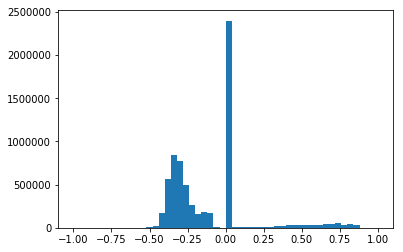

In [13]:
fig, axs = plt.subplots()

# We can set the number of bins with the `bins` kwarg
axs.hist(ndvi.flatten(), bins=50)
fig.show()

NDVI looks normal, let's check out the whole image histogram:

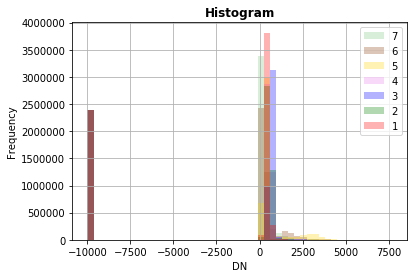

In [14]:
rasterio.plot.show_hist(landsat_dataset.read([1,2,3,4,5,6,7]), bins=50, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3)

Now we'll visualize the landsat image and NDVI side by side:

(3, 4475, 1481)
(4475, 1481, 3)


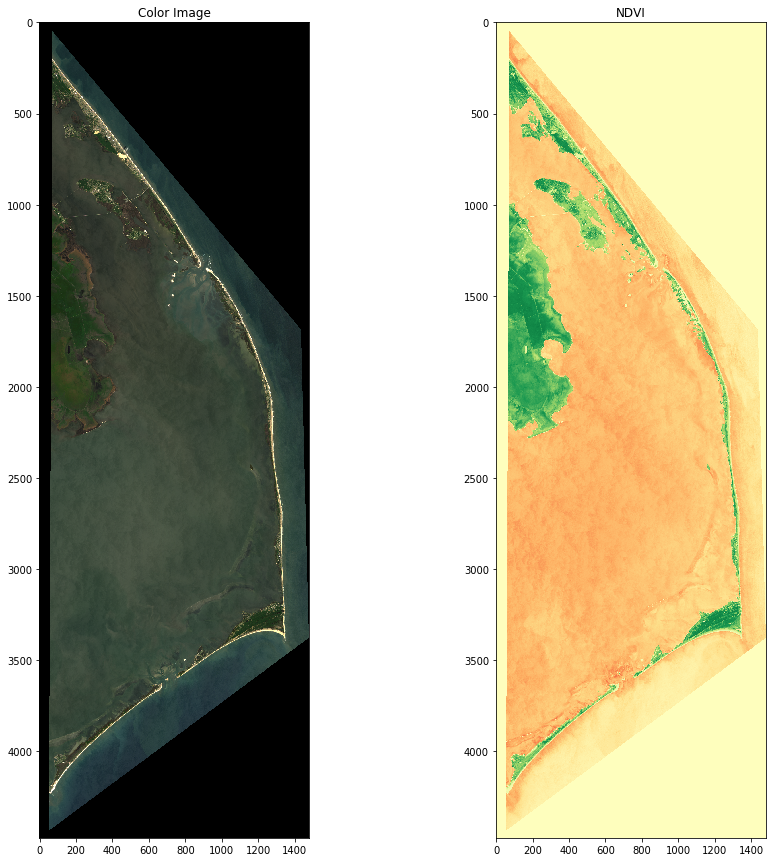

In [15]:
from rasterio.plot import adjust_band
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show

# pull out the bands we want to visualize
index = np.array([3, 2, 1])
colors = landsat_image[index, :, :].astype(np.float64)

# we'll use the values to stretch the landsat image based on the above histogram
max_val = 2500
min_val = 0

# enforce maximum and minimum values
colors[colors[:, :, :] > max_val] = max_val
colors[colors[:, :, :] < min_val] = min_val

for b in range(colors.shape[0]):
    colors[b, :, :] = colors[b, :, :] * 1 / (max_val - min_val)

# rasters are in the format [bands, rows, cols] whereas images are typically [rows, cols, bands]
# and so our array needs to be reshaped
print(colors.shape)
colors_reshaped = reshape_as_image(colors)
print(colors_reshaped.shape)


fig, axs = plt.subplots(1, 2, figsize=(15, 15)) 

# Show the color image
axs[0].imshow(colors_reshaped)
axs[0].set_title('Color Image')

# Show NDVI
axs[1].imshow(ndvi, cmap='RdYlGn')
axs[1].set_title('NDVI')

fig.show()

Now let's check out the quality band

[  0   1 322 324 328 352 386 388 392 416 480]


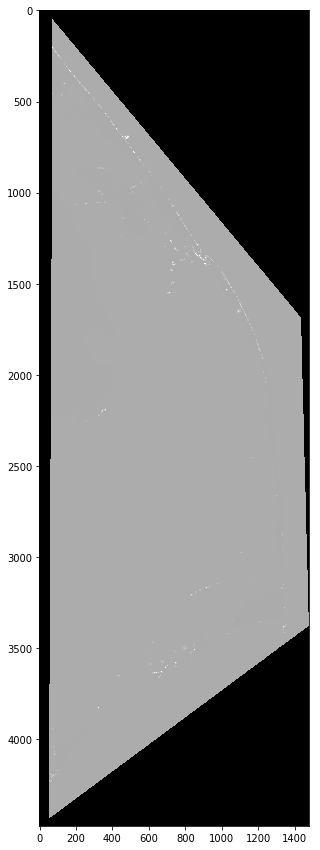

In [17]:
qa_band = landsat_image[7, :, :]
qa_band[qa_band == -9999] = 0

print(np.unique(qa_band))

fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(qa_band, cmap='gray')

Read in the training labels image

In [18]:
labels_dataset = rasterio.open('data/labels_image.tif')
# we're merging here just to limit the number of classes we're working with
labels_image = merge_classes(labels_dataset.read())
labels_image.shape

(1, 4476, 1482)

How many pixels are there of each class?

In [19]:
unique, counts = np.unique(labels_image, return_counts=True)
list(zip(unique, counts))

[(0, 2189505),
 (2, 53319),
 (6, 15131),
 (8, 6340),
 (11, 233678),
 (18, 272903),
 (20, 40077),
 (21, 3822479)]

Let's view the training labels:

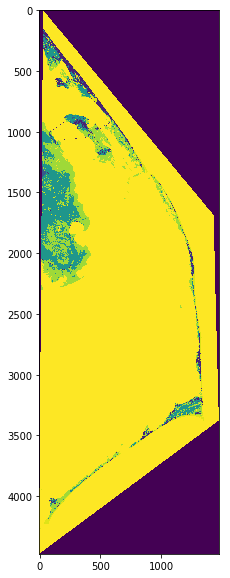

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
# we then use these objects to draw-on and manipulate our plot
ax.imshow(labels_image[0])

Now with a more logical color map:


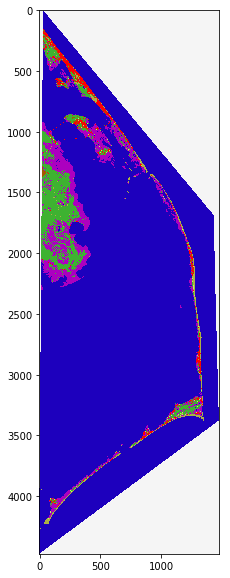

In [21]:
# next setup a colormap for our map
colors = dict((
(0, (245,245,245, 255)), # Background
(1, (0,0,0)), # Unclassified (Cloud, Shadow, etc)
(2, (255,0,0)), # High Intensity Developed
(3, (255, 110, 51)), # Medium Intensity Developed
(4, (255, 162, 51)), # Low Intensity Developed
(5, (255, 162, 51)), # Open Space Developed
(6, (162, 89, 0)), # Cultivated Land
(7, (229, 221, 50)), # Pasture/Hay
(8, (185, 251, 96)), # Grassland
(9, (83, 144, 0)), # Deciduous Forest
(10, (13, 118, 0  )), # Evergreen Forest
(11, (62, 178, 49)), # Mixed Forest
(12, (100, 241, 125)), # Scrub/Shrub
(13, (68, 160, 85)), # Palustrine Forested Wetland
(14, (118, 192, 131)), # Palustrine Scrub/Shrub Wetland
(15, (188, 0, 211)), # Palustrine Emergent Wetland
(16, (188, 0, 211)), # Estuarine Forested Wetland
(17, (0, 0, 0)), # Estuarine Scrub/Shrub Wetland
(18, (172, 0, 191)), # Estuarine Emergent Wetland
(19, (159, 251, 255)), # Unconsolidated Shore 
(20, (172, 177, 68)), # Bare Land
(21, (29, 0, 189)), # Water
(22, (40, 40, 40)), # Pal Bed
))

n = int(np.max(labels_image)) + 1


# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] for key in range(0, n)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

# Now show the class map next to the RGB image

fig, axs = plt.subplots(figsize=(10,10))

axs.imshow(labels_image[0,:, :], cmap=cmap, interpolation='none')

Generate a set of random class balanced pixel locations:

In [22]:
train_pixels = gen_balanced_pixel_locations([landsat_dataset], train_count=8000, 
                                            label_dataset=labels_dataset, merge=True)


100%|██████████| 1/1 [01:39<00:00, 99.86s/it]


In [23]:
landsat_datasets = [landsat_dataset]
# generate the training and validation pixel locations
all_labels = []
label_locations = []
for pixel in train_pixels:
    # row, col location in landsat
    r,c = pixel[0]
    ds_index = pixel[1]
    l8_proj = Proj(landsat_datasets[ds_index].crs)
    label_proj = Proj(labels_dataset.crs)
    
    # geographic location in landsat
    x,y = landsat_datasets[ds_index].xy(r,c)
    # go from label projection into landsat projection
    x,y = transform(l8_proj, label_proj ,x,y)
    # get row and col location in label
    r,c = labels_dataset.index(x,y)
    
    label_locations.append([r,c])
    
    # format (bands, height, width)
    window = ((r, r+1), (c, c+1))
    data = merge_classes(labels_dataset.read(1, window=window, masked=False, boundless=True))
    all_labels.append(data[0,0])
    
label_locations = np.array(label_locations)

unique, counts = np.unique(np.array(all_labels), return_counts=True)
dict(zip(unique, counts))

{0: 1000, 2: 1000, 6: 1000, 8: 1000, 11: 1000, 18: 1000, 20: 1000, 21: 1000}

Visualize the location of those pixels on the label image:

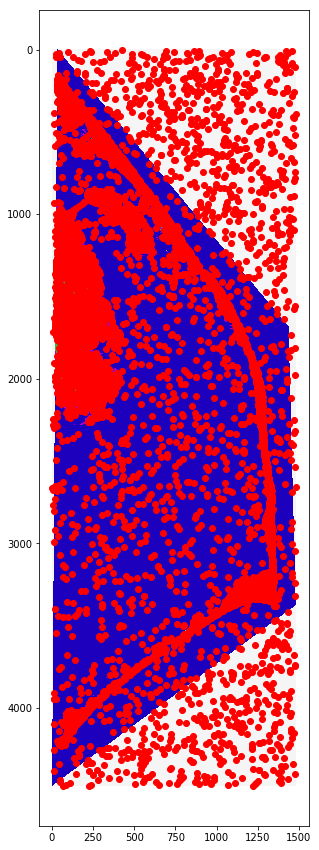

In [24]:
fig, ax = plt.subplots(figsize=[15,15])

ax.imshow(labels_image[0,:, :], cmap=cmap, interpolation='none')

plt.scatter(label_locations[:, 1], label_locations[:, 0], c='r')

Note that there are lots of pixels generated in areas that don't actually have data. We'll filter that out in the data generator.

#### Test out the generator:

Print out some image and label batches and check out their shapes.

In [50]:
im_batch = None

count = 0
for (im, label) in tile_generator(landsat_datasets, labels_dataset, 128, 128, train_pixels, 10):
    if count > 3:
        break
    print('Image')
    print(im.shape)
    print('Label')
    print(label.shape)
    print('----')
    count += 1
    im_batch = im

Image
(10, 128, 128, 7)
Label
(10, 26)
----
Image
(10, 128, 128, 7)
Label
(10, 26)
----
Image
(10, 128, 128, 7)
Label
(10, 26)
----
Image
(10, 128, 128, 7)
Label
(10, 26)
----


Now let's visualize the actual tiles. Note they'll look unnatural because they have been normalized.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


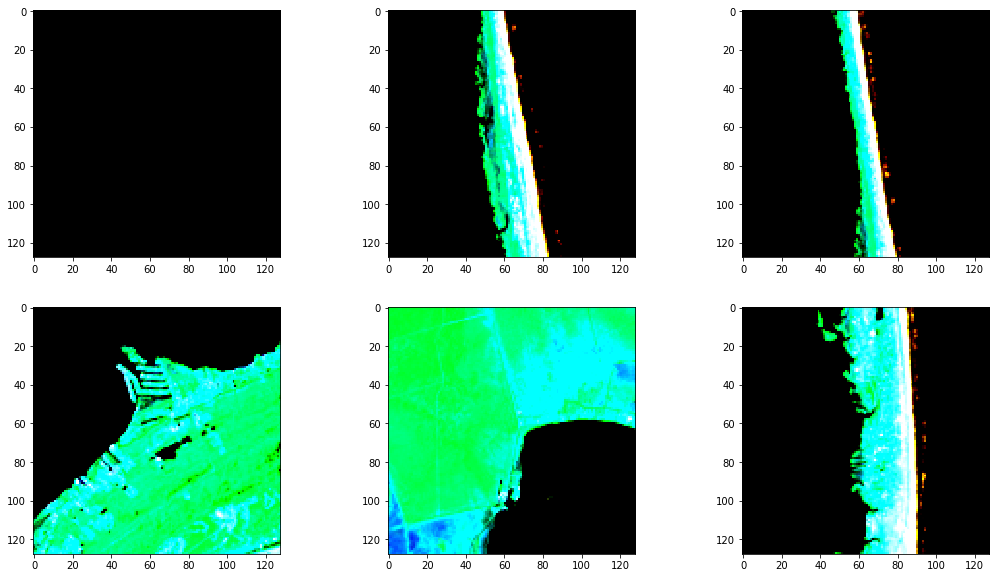

In [26]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10)) 

axs[0,0].imshow(im_batch[0,:,:,3:6])
axs[0,1].imshow(im_batch[1,:,:,3:6])
axs[0,2].imshow(im_batch[2,:,:,3:6])
axs[1,0].imshow(im_batch[3,:,:,3:6])
axs[1,1].imshow(im_batch[4,:,:,3:6])
axs[1,2].imshow(im_batch[5,:,:,3:6])

fig.show()

### Explore the data:

#### Generate training dataset of 1x1 tiles for scikit-learn to visualize data

In [27]:
im_batch = None
label_batch = None

sample_size = 500

count = 0
for (im, label) in tile_generator(landsat_datasets, labels_dataset, 1, 1, train_pixels, sample_size):
    if count > 0:
        break
    print('Batch Shape')
    print(im.shape)
    print('Label Shape')
    print(label.shape)
    print('----')
    count += 1
    im_batch = im
    label_batch = label

Batch Shape
(500, 1, 1, 7)
Label Shape
(500, 26)
----


Reshape because scikit-learn needs daya in `(samples, bands)` format:

In [28]:
im_batch[0,:,:,:]

array([[[-0.63307013, -0.63399907, -0.41477009, -0.64700418,
          2.73618207,  0.45657222, -0.34509986]]])

In [29]:
im_batch_reshaped = im_batch.reshape(sample_size,7)
im_batch_reshaped[0]

array([-0.63307013, -0.63399907, -0.41477009, -0.64700418,  2.73618207,
        0.45657222, -0.34509986])

#### Visualize Spectral Signatures

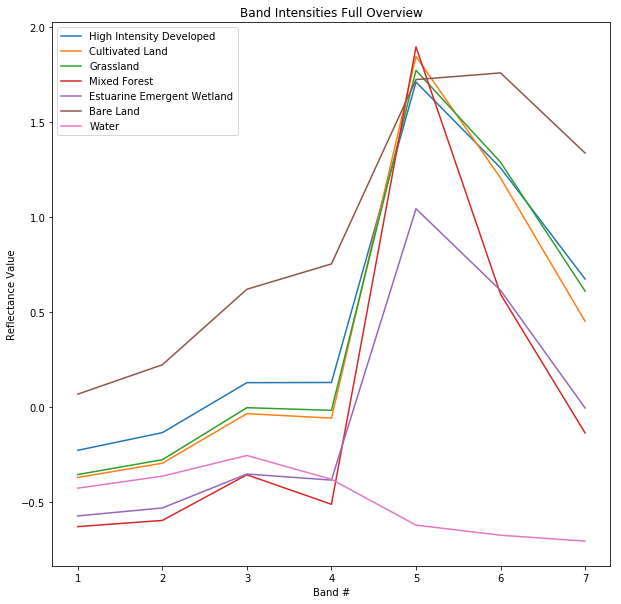

In [30]:
fig, ax = plt.subplots(1,1, figsize=[10,10])

# numbers 1-8
band_count = np.arange(1,8)

y = np.argmax(label_batch, axis=1)
X = im_batch_reshaped

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    ax.plot(band_count, band_intensity, label=class_names[class_type])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a title
ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left')

#### Run Principle Components Analysis to visualize points

In [31]:
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
pca_result = pca.fit_transform(im_batch_reshaped)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

df = pd.DataFrame({'pca-one':pca_result[:,0],'pca-two':pca_result[:,1],'pca-three':pca_result[:,2], 'y' : np.argmax(label_batch, axis=1)})

Explained variation per principal component: [0.77292618 0.18454464 0.03824837]


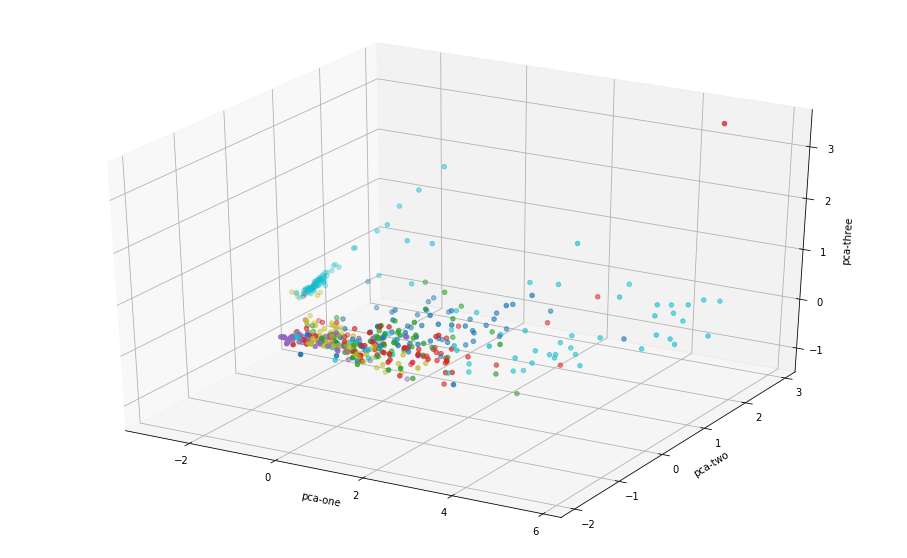

In [32]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df["pca-one"], 
    ys=df["pca-two"], 
    zs=df["pca-three"], 
    c=df["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

#### Run T-distributed Stochastic Neighbor Embedding (t-SNE) to visualize points

In [33]:
from time import time
from sklearn.manifold import TSNE


time_start = time()
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=1000)
tsne_results = tsne.fit_transform(im_batch_reshaped)
print('t-SNE done! Time elapsed: {} seconds'.format(time()-time_start))

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.620043
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.865753
[t-SNE] KL divergence after 1000 iterations: 0.179326
t-SNE done! Time elapsed: 3.996859550476074 seconds


In [0]:
df_subset = df.copy()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

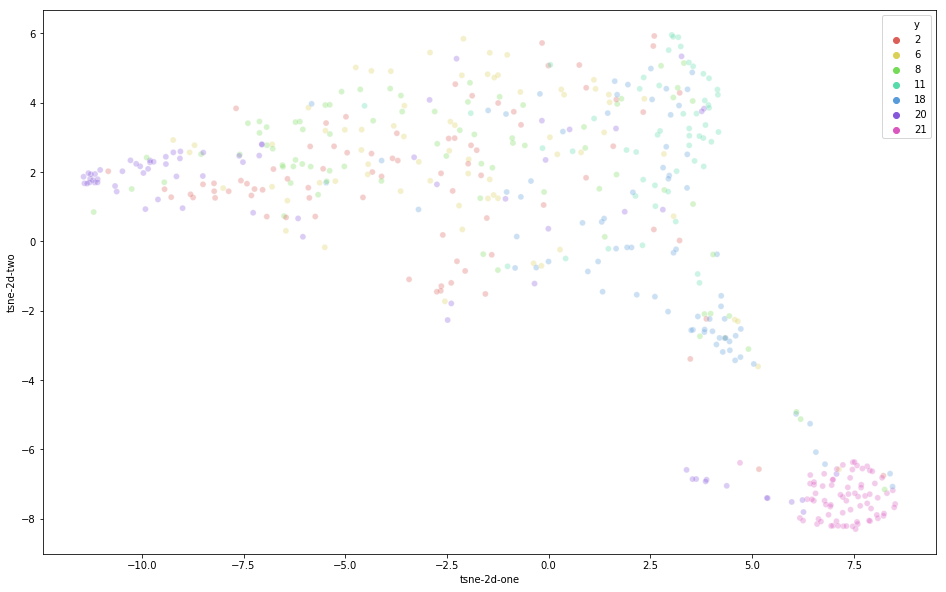

In [35]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", len(np.unique(np.argmax(label_batch, axis=1)))),
    data=df_subset,
    legend="full",
    alpha=0.3
)

#### Generate training dataset of 1x1 tiles for scikit-learn to use in Random Forest and KNN

In [36]:
im_batch = None
label_batch = None

sample_size = 2000
train_count = 1500
val_count = 500

count = 0
for (im, label) in tile_generator(landsat_datasets, labels_dataset, 1, 1, train_pixels, sample_size):
    if count > 0:
        break
    print('Batch Shape')
    print(im.shape)
    print('Label Shape')
    print(label.shape)
    print('----')
    count += 1
    im_batch = im
    label_batch = label

im_batch_reshaped = im_batch.reshape(sample_size,7)

X_train = im_batch_reshaped[:train_count]
X_val = im_batch_reshaped[train_count:]
y_train = np.argmax(label_batch, axis=1)[:train_count]
y_val = np.argmax(label_batch, axis=1)[train_count:]

Batch Shape
(2000, 1, 1, 7)
Label Shape
(2000, 26)
----


#### Run K Nearest Neighbors

In [37]:
from sklearn import neighbors, datasets

n_neighbors = 50

clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(X_train, y_train)

clf.score(X_val, y_val)

0.6

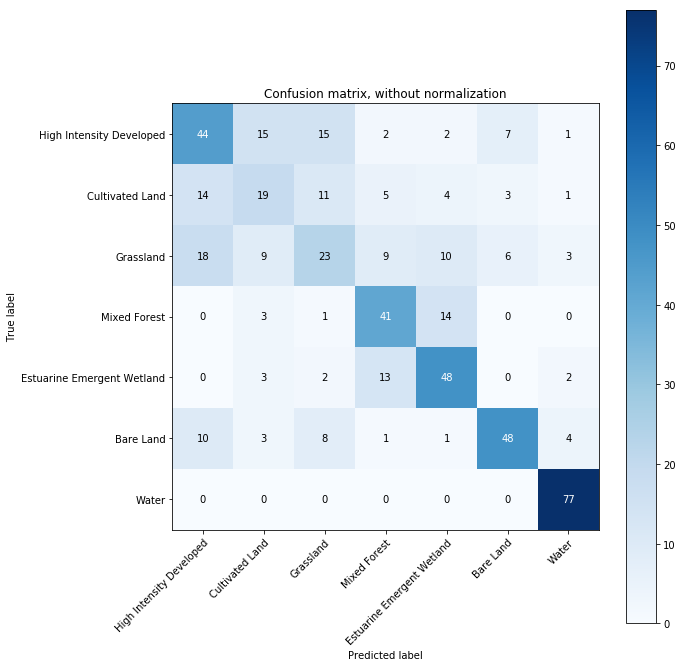

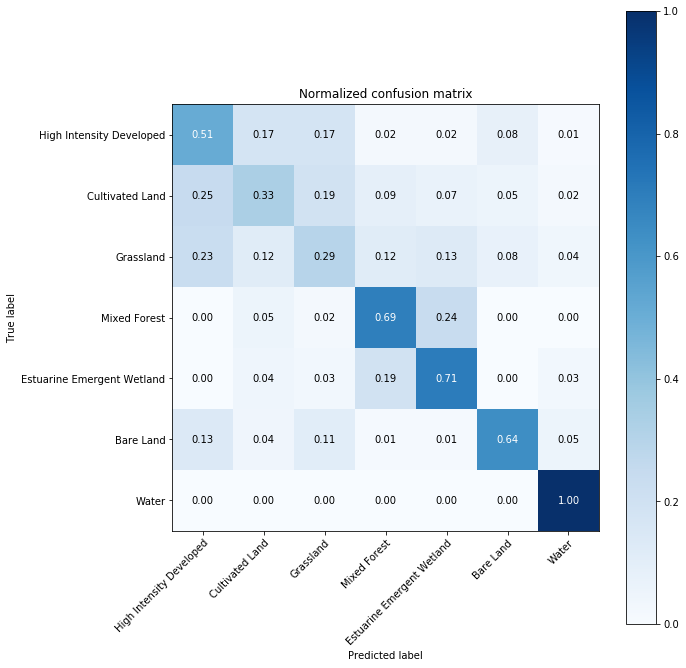

In [38]:
pred_index = clf.predict(X_val)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_val, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(y_val, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

#### Run Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(X_train, y_train)

print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

print(rf.score(X_val, y_val))

Our OOB prediction of accuracy is: 57.8%
0.588
Band 1 importance: 0.11957562114935275
Band 2 importance: 0.1159050848394094
Band 3 importance: 0.137735042815471
Band 4 importance: 0.12440603999529606
Band 5 importance: 0.1856699698715294
Band 6 importance: 0.1589309011120682
Band 7 importance: 0.15777734021687334


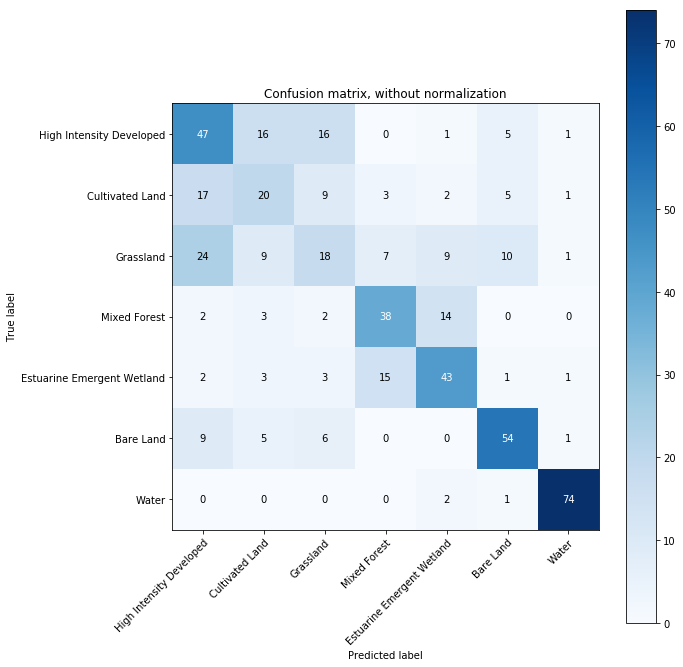

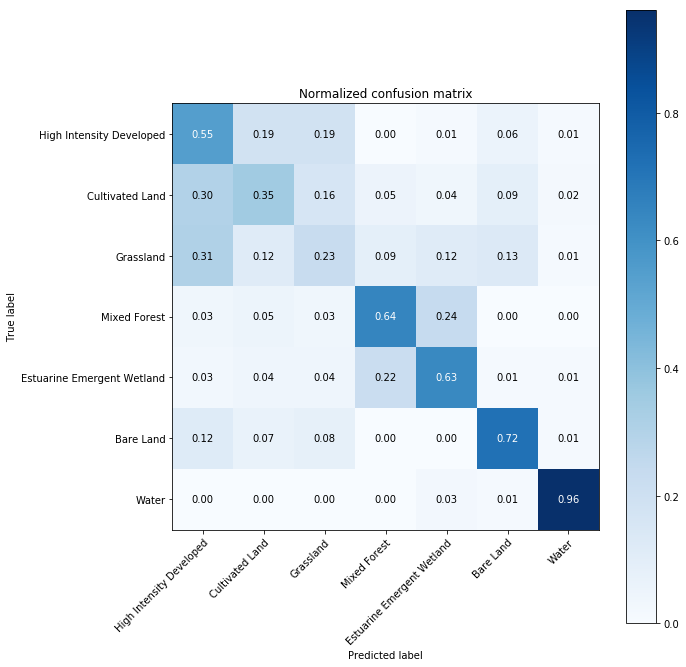

In [40]:
pred_index = rf.predict(X_val)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_val, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(y_val, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

### Now let's build the actual neural network model!

Import all the necessary `keras` packages

In [41]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, BatchNormalization
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


Set the hyperparameters

In [42]:
batch_size = 25
epochs = 25
num_classes = len(class_names)

# input image dimensions
tile_side = 32
img_rows, img_cols = tile_side, tile_side
img_bands = landsat_datasets[0].count- 1

input_shape = (img_rows, img_cols, img_bands)
print(input_shape)

(32, 32, 7)


#### Create the CNN architecture:

In [43]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

W0615 21:08:00.180056 139660576839552 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0615 21:08:00.218027 139660576839552 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0615 21:08:00.224033 139660576839552 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0615 21:08:00.261261 139660576839552 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0615 21:08:00.262108 1396605768

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        2048      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
__________

Divide data into training and validation:

In [54]:
train_to_val_ratio = 0.8
train_px = train_pixels[:int(len(train_pixels)*train_to_val_ratio)]
val_px = train_pixels[int(len(train_pixels)*train_to_val_ratio):]
print("Train:", len(train_px), "\nVal:", len(val_px))

Train: 6400 
Val: 1600


Decide on the optimizier and compile the model:

In [45]:
sgd = keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
metrics=['accuracy']

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=metrics)

W0615 21:08:04.002366 139660576839552 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



### Learn the model:

<img src="https://i.imgur.com/vFCeROF.png" alt="drawing" width="500"/>

Image from the excellent *Deep Learning with Python* by François Chollet

In [46]:
history = model.fit_generator(generator=tile_generator(landsat_datasets, labels_dataset, tile_side, tile_side, train_px, batch_size, merge=True), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
                    validation_data=tile_generator(landsat_datasets, labels_dataset, tile_side, tile_side, val_px, batch_size, merge=True),
                    validation_steps=len(val_px) // batch_size)

plt.figure(figsize=(10,10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

W0615 21:08:04.131339 139660576839552 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/25
256/256 [==============================] - 27s 106ms/step - loss: 2.5769 - acc: 0.3233 - val_loss: 1.8150 - val_acc: 0.5744
Epoch 2/25
256/256 [==============================] - 22s 86ms/step - loss: 1.8181 - acc: 0.5161 - val_loss: 1.5297 - val_acc: 0.6006
Epoch 3/25
256/256 [==============================] - 22s 86ms/step - loss: 1.5400 - acc: 0.5666 - val_loss: 1.2671 - val_acc: 0.6400
Epoch 4/25
256/256 [==============================] - 22s 86ms/step - loss: 1.3848 - acc: 0.5853 - val_loss: 1.2149 - val_acc: 0.6469
Epoch 5/25
256/256 [==============================] - 22s 86ms/step - loss: 1.2753 - acc: 0.6000 - val_loss: 1.1217 - val_acc: 0.6600
Epoch 6/25
256/256 [==============================] - 22s 86ms/step - loss: 1.1984 - acc: 0.6202 - val_loss: 1.0371 - val_acc: 0.6694
Epoch 7/25
256/256 [==============================] - 22s 87ms/step - loss: 1.1440 - acc: 0.6205 - val_loss: 1.0575 - val_acc: 0.6619
Epoch 8/25
256/256 [==============================] - 22s 86m

KeyboardInterrupt: ignored

Hopefully we found our way down here:

<img src="https://science.sciencemag.org/content/sci/360/6388/478/F1.large.jpg" alt="drawing" width="500"/>

Image from: http://doi.org/10.1126/science.360.6388.478

#### Check out accuracy based on a confusion matrix:

64/64 [==============================] - 4s 67ms/step


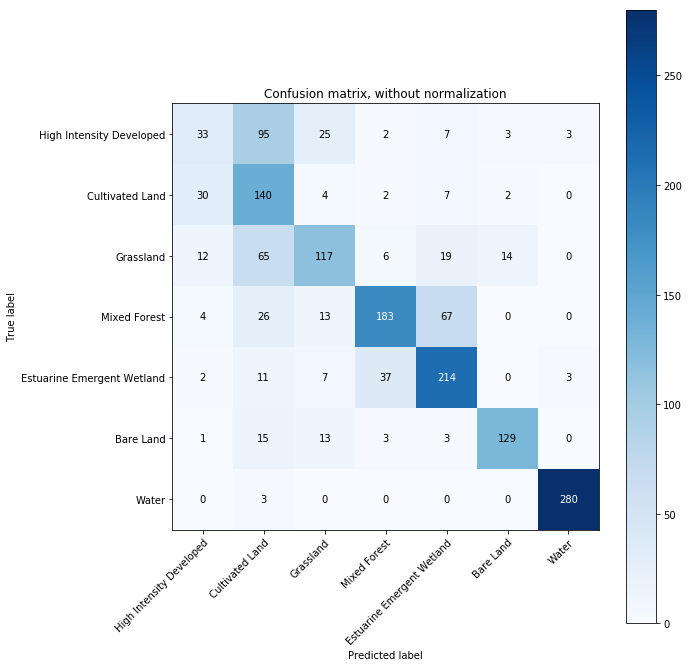

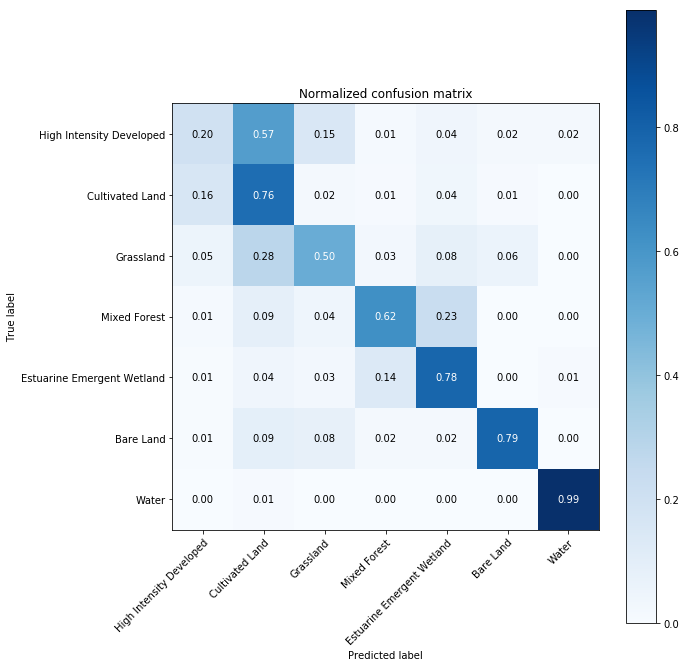

In [48]:
predictions = model.predict_generator(generator=tile_generator(landsat_datasets, labels_dataset, tile_side, tile_side, val_px, batch_size, merge=True), 
                        steps=len(val_px) // batch_size,
                         verbose=1)

eval_generator = tile_generator(landsat_datasets, labels_dataset, tile_side, tile_side, val_px, batch_size=1, merge=True)

labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1
    
label_index = np.argmax(labels, axis=1)     
pred_index = np.argmax(predictions, axis=1)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

How well does the model predict on the training data?

64/64 [==============================] - 4s 65ms/step


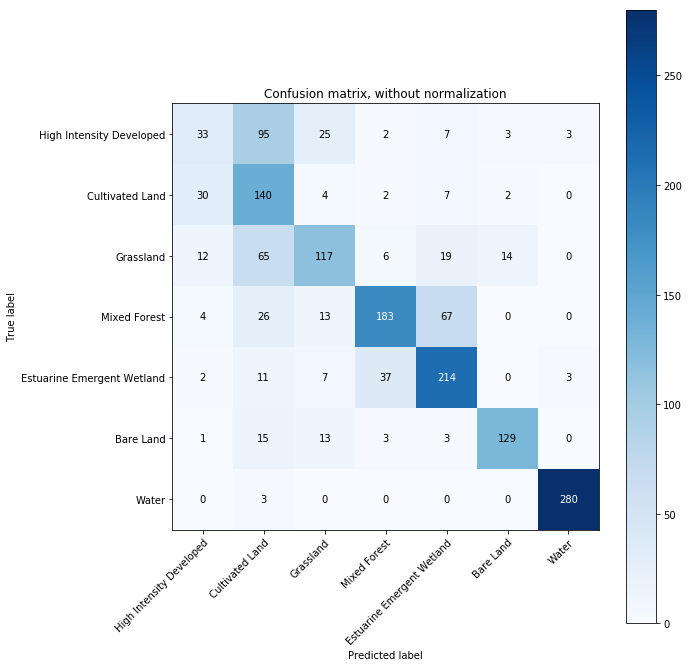

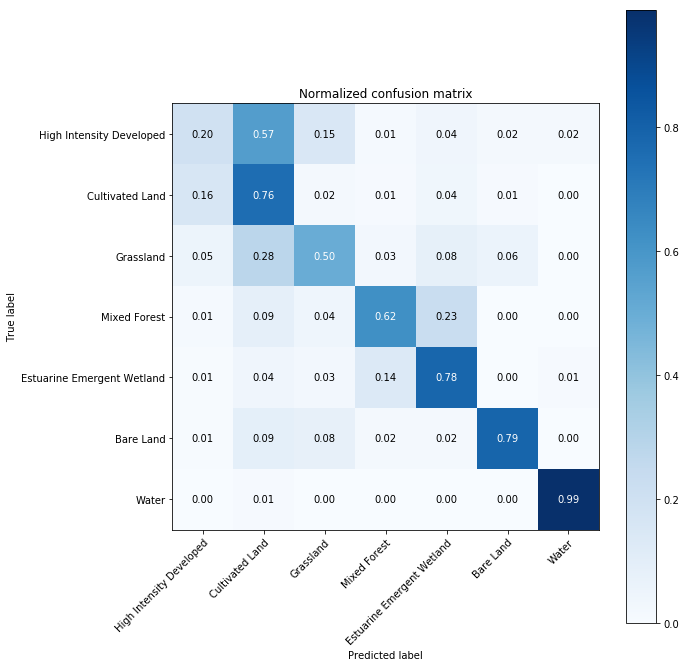

In [49]:
predictions = model.predict_generator(generator=tile_generator(landsat_datasets, labels_dataset, tile_side, tile_side, val_px, batch_size, merge=True), 
                        steps=len(val_px) // batch_size,
                         verbose=1)

eval_generator = tile_generator(landsat_datasets, labels_dataset, tile_side, tile_side, val_px, batch_size=1, merge=True)

labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1
    
label_index = np.argmax(labels, axis=1)     
pred_index = np.argmax(predictions, axis=1)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)